In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-data-challenge/t2_user_variant.csv
/kaggle/input/quora-data-challenge/table_schema.txt
/kaggle/input/quora-data-challenge/t1_user_active_min.csv
/kaggle/input/quora-data-challenge/t3_user_active_min_pre.csv
/kaggle/input/quora-data-challenge/t4_user_attributes.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.stats.api as sms

### Importing the datasets

In [3]:
df1 = pd.read_csv('../input/quora-data-challenge/t1_user_active_min.csv')
df2 = pd.read_csv('../input/quora-data-challenge/t2_user_variant.csv')

df1: How much time every user spent on the website during the experiment

df2: Whether a user was in the treatment or control group

In [4]:
# df1 = how much time each user spent on the website on a day during the experiment
df1.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [5]:
# df2 = whether a user was in the treatment or control group (variant_number = 0 -> control) (variant_number = 1 -> treatment)
df2.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


### Checking for outliers

In [6]:
df1.sort_values('active_mins', ascending=False)

,uid,dt,active_mins
699598,31734,2019-05-19,99999.0
424289,19136,2019-03-10,99999.0
69742,3124,2019-05-10,99999.0
69745,3124,2019-05-16,99999.0
1057133,49503,2019-03-10,99999.0
...,...,...,...
294385,13273,2019-04-02,1.0
294388,13273,2019-05-05,1.0
610819,27604,2019-03-06,1.0
677405,30721,2019-06-18,1.0


In [7]:
maxMins = max(df1['active_mins'])
maxMins

99999.0

In [8]:
df1[df1['active_mins'] != maxMins].sort_values('active_mins', ascending=False)

,uid,dt,active_mins
53105,2398,2019-02-24,897.0
495393,22230,2019-04-03,896.0
925607,42198,2019-04-14,895.0
424321,19136,2019-04-23,894.0
53131,2398,2019-04-06,894.0
...,...,...,...
141105,6330,2019-03-31,1.0
312977,14137,2019-06-10,1.0
946384,43376,2019-03-18,1.0
860278,38836,2019-03-21,1.0


There are several rows that claim to have spent 99999 minutes on the website, which is significantly higher than the second highest value of 897 minutes. This suggests that there were likely to be logging errors for the rows with 99999 minutes. These rows will be removed from the data.

In [9]:
df1_filtered = df1[df1['active_mins'] != maxMins]

In [10]:
df1_filtered.sort_values('active_mins', ascending=False).head()

,uid,dt,active_mins
53105,2398,2019-02-24,897.0
495393,22230,2019-04-03,896.0
925607,42198,2019-04-14,895.0
424321,19136,2019-04-23,894.0
53131,2398,2019-04-06,894.0


In [11]:
df1_grouped = df1_filtered.groupby(by='uid').sum()
df1_grouped.sort_values('active_mins', ascending=False).head()

,active_mins
uid,
49503,46742.0
42198,42055.0
19136,37191.0
22230,36506.0
39773,34849.0


The total active_mins for each user has been collected in the table above, but the variant_number was messed up by the sum() function.

### Joining user_active_min data with user_variant data

The user_active_min data will be joined with the user_variant data on 'uid'. This will allow us to see how much time each user spent and which experimental group they were in.

In [12]:
users = df1_grouped.merge(df2, on='uid')
users.head()

,uid,active_mins,variant_number,dt,signup_date
0,0,43.0,0,2019-02-06,2018-09-24
1,1,15205.0,0,2019-02-06,2016-11-07
2,2,17.0,0,2019-02-06,2018-09-17
3,3,77.0,0,2019-02-06,2018-03-04
4,4,39.0,0,2019-02-06,2017-03-09


In [13]:
control = users[users['variant_number'] == 0] # control group
treat = users[users['variant_number'] == 1] # treatment group

In [14]:
control.head()

,uid,active_mins,variant_number,dt,signup_date
0,0,43.0,0,2019-02-06,2018-09-24
1,1,15205.0,0,2019-02-06,2016-11-07
2,2,17.0,0,2019-02-06,2018-09-17
3,3,77.0,0,2019-02-06,2018-03-04
4,4,39.0,0,2019-02-06,2017-03-09


In [15]:
treat.head()

,uid,active_mins,variant_number,dt,signup_date
37425,40000,25.0,1,2019-02-06,2019-02-04
37426,40001,299.0,1,2019-02-06,2017-04-29
37427,40002,183.0,1,2019-02-06,2015-08-22
37428,40004,56.0,1,2019-02-06,2015-04-12
37429,40005,289.0,1,2019-02-06,2017-03-05


In [16]:
np.mean(treat['active_mins'])

458.4024761077324

In [17]:
np.mean(control['active_mins'])

458.2211623246493

## Checking variations of the two groups using Levene's test

In [18]:
import scipy.stats as stats

stats.levene(treat['active_mins'],
             control['active_mins'],
             center= 'mean')

LeveneResult(statistic=2.4355495589285394, pvalue=0.11861910565686667)

The p-value of Levene's test is greater than 0.05, which means that there is not enough evidence to reject the null hypothesis that the two groups have equal variances. We will assume that the two groups have the same variance, so a pooled t-test will be used to find the confidence interval.

## Finding the t-test CI

In [19]:
r = sms.CompareMeans(sms.DescrStatsW(treat['active_mins']), sms.DescrStatsW(control['active_mins']), )

r.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(-37.64085130442592, 38.00347887059215)

**95% Confidence Interval: (-37.64, 38.00) minutes**

We are 95% confident that the true difference between the treatment group's mean and the control group's mean is between -38 and +38 minutes. One factor to note is that the confidence interval is quite wide. If the interval were much narrower like -1 and +1 minutes, then I would suggest not pushing to production, but in this case the wide confidence interval suggests that more research may be needed.

### Including the user data from before the experiment

The pre-experiment data can be used to determine how much variance existed prior to the experiment. This information can then be used to potentially find a narrower 95% confidence interval.

In [20]:
df3 = pd.read_csv('../input/quora-data-challenge/t3_user_active_min_pre.csv')
df3.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


### Getting rid of outliers

In [21]:
maxMins3 = max(df3['active_mins'])
maxMins3

99999.0

In [22]:
df3_filtered = df3[df3['active_mins'] != maxMins3]
df3_filtered.sort_values('active_mins', ascending=False).head()

,uid,dt,active_mins
386278,15516,2018-09-25,897.0
553056,22230,2019-01-06,896.0
983780,39773,2018-09-21,895.0
474790,19136,2019-01-27,894.0
947093,38304,2018-10-01,893.0


In [23]:
df3_grouped = df3_filtered.groupby('uid').sum()
df3_grouped

,active_mins
uid,
0,70.0
1,19158.0
2,37.0
3,108.0
4,66.0
...,...
49995,34.0
49996,243.0
49997,83.0


### Joining all of the datasets by 'uid'

In [24]:
usersAll = df3_grouped.merge(users, on='uid')
usersAll = usersAll.rename(columns={"active_mins_x": "active_mins_pre", "active_mins_y": "active_mins_during"})
usersAll

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date
0,0,70.0,43.0,0,2019-02-06,2018-09-24
1,1,19158.0,15205.0,0,2019-02-06,2016-11-07
2,2,37.0,17.0,0,2019-02-06,2018-09-17
3,3,108.0,77.0,0,2019-02-06,2018-03-04
4,4,66.0,39.0,0,2019-02-06,2017-03-09
...,...,...,...,...,...,...
46473,49995,34.0,95.0,1,2019-02-06,2018-10-11
46474,49996,243.0,156.0,1,2019-02-06,2014-12-06
46475,49997,83.0,379.0,1,2019-02-06,2018-11-15
46476,49998,124.0,597.0,1,2019-02-06,2016-04-05


### CUPED Method

The CUPED method will be used to used to account for the variance that already existed in the data pre-experiment.

In [25]:
covarianceMatrix = np.cov(usersAll['active_mins_during'], usersAll['active_mins_pre'])
covarianceMatrix

array([[2760204.92147234, 2435341.38541061],
       [2435341.38541061, 3075550.56418511]])

In [26]:
covariance = covarianceMatrix[0][1]
covariance

2435341.3854106083

In [27]:
variance = np.cov(usersAll['active_mins_pre']) # variance of the pre-experiment data
variance

array(3075550.56418511)

In [28]:
theta = covariance / variance
theta

0.7918391632933103

Now we will use theta to calculate the CUPED adjusted active minutes.

In [29]:
usersAll

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date
0,0,70.0,43.0,0,2019-02-06,2018-09-24
1,1,19158.0,15205.0,0,2019-02-06,2016-11-07
2,2,37.0,17.0,0,2019-02-06,2018-09-17
3,3,108.0,77.0,0,2019-02-06,2018-03-04
4,4,66.0,39.0,0,2019-02-06,2017-03-09
...,...,...,...,...,...,...
46473,49995,34.0,95.0,1,2019-02-06,2018-10-11
46474,49996,243.0,156.0,1,2019-02-06,2014-12-06
46475,49997,83.0,379.0,1,2019-02-06,2018-11-15
46476,49998,124.0,597.0,1,2019-02-06,2016-04-05


In [30]:
meanPre = np.mean(usersAll['active_mins_pre'])
meanPre

465.227397908688

In [31]:
usersAll['adjusted_mins'] = usersAll['active_mins_during'] - (usersAll['active_mins_pre'] - meanPre) * theta
usersAll

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date,adjusted_mins
0,0,70.0,43.0,0,2019-02-06,2018-09-24,355.956532
1,1,19158.0,15205.0,0,2019-02-06,2016-11-07,403.330583
2,2,37.0,17.0,0,2019-02-06,2018-09-17,356.087224
3,3,108.0,77.0,0,2019-02-06,2018-03-04,359.866644
4,4,66.0,39.0,0,2019-02-06,2017-03-09,355.123889
...,...,...,...,...,...,...,...
46473,49995,34.0,95.0,1,2019-02-06,2018-10-11,436.462742
46474,49996,243.0,156.0,1,2019-02-06,2014-12-06,331.968357
46475,49997,83.0,379.0,1,2019-02-06,2018-11-15,681.662623
46476,49998,124.0,597.0,1,2019-02-06,2016-04-05,867.197217


### t-test with the CUPED-adjusted minutes

In [32]:
treatAll = usersAll[usersAll['variant_number'] == 1]
treatAll.head()

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date,adjusted_mins
37313,40001,125.0,299.0,1,2019-02-06,2017-04-29,568.405378
37314,40002,90.0,183.0,1,2019-02-06,2015-08-22,480.119749
37315,40004,10.0,56.0,1,2019-02-06,2015-04-12,416.466882
37316,40005,638.0,289.0,1,2019-02-06,2017-03-05,152.191887
37317,40006,64.0,194.0,1,2019-02-06,2016-06-17,511.707567


In [33]:
controlAll = usersAll[usersAll['variant_number'] == 0]
controlAll.head()

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date,adjusted_mins
0,0,70.0,43.0,0,2019-02-06,2018-09-24,355.956532
1,1,19158.0,15205.0,0,2019-02-06,2016-11-07,403.330583
2,2,37.0,17.0,0,2019-02-06,2018-09-17,356.087224
3,3,108.0,77.0,0,2019-02-06,2018-03-04,359.866644
4,4,66.0,39.0,0,2019-02-06,2017-03-09,355.123889


In [34]:
np.mean(controlAll['active_mins_during'])

459.54482351995284

In [35]:
np.mean(treatAll['active_mins_during'])

460.4651391162029

In [36]:
np.mean(controlAll['adjusted_mins'])

426.5941215844329

In [37]:
np.mean(treatAll['adjusted_mins'])

594.6156619007294

In [38]:
stats.levene(treatAll['adjusted_mins'],
             controlAll['adjusted_mins'],
             center= 'mean')

LeveneResult(statistic=166.62228425638753, pvalue=4.703419949450182e-38)

The p-value of the Levene's test is less than 0.05, so there is sufficient evidence to reject the null hypothesis that the two samples have the same variance. Since this is the case, the Welch's t-test will be used.

In [39]:
r = sms.CompareMeans(sms.DescrStatsW(treatAll['adjusted_mins']), sms.DescrStatsW(controlAll['adjusted_mins']), )

r.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='unequal')

(143.8923112172685, 192.15076941532033)

**95% Confidence Interval: (143.89, 192.15) minutes**

Based on the new confidence interval, we are 95% confident that the true difference in the amount of time spent between the two groups is between 143.89 and 192.15 minutes. Since the confidence interval does not include the value 0, there is sufficient evidence to reject the null hypothesis that there is no difference between the two groups. Based on these findings, I would suggest pushing this UI change into production.

The CUPED method took into account the variance that existed in the groups prior to the experiment. The covariance between the pre-experiment and experiment data was divided by the variance of the pre-experiment data to calculate theta. Theta was then used to calculate an adjusted active minutes spent on the website that takes into account variance that is unrelated to the treatment effects of the experiment. 

### Analyzing Table 4: User Attributes

In [40]:
df4 = pd.read_csv('../input/quora-data-challenge/t4_user_attributes.csv')

In [41]:
df4 # user_type: segment that a user belongs to, measured by activity level of the user. Can be ‘new_user’, ‘non_reader’, ‘reader’ or ‘contributor’

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader
...,...,...,...
49995,49995,unknown,non_reader
49996,49996,male,non_reader
49997,49997,female,reader
49998,49998,male,non_reader


In [42]:
allTables = usersAll.merge(df4, on='uid')
allTables

,uid,active_mins_pre,active_mins_during,variant_number,dt,signup_date,adjusted_mins,gender,user_type
0,0,70.0,43.0,0,2019-02-06,2018-09-24,355.956532,male,non_reader
1,1,19158.0,15205.0,0,2019-02-06,2016-11-07,403.330583,male,reader
2,2,37.0,17.0,0,2019-02-06,2018-09-17,356.087224,male,non_reader
3,3,108.0,77.0,0,2019-02-06,2018-03-04,359.866644,male,non_reader
4,4,66.0,39.0,0,2019-02-06,2017-03-09,355.123889,male,non_reader
...,...,...,...,...,...,...,...,...,...
46473,49995,34.0,95.0,1,2019-02-06,2018-10-11,436.462742,unknown,non_reader
46474,49996,243.0,156.0,1,2019-02-06,2014-12-06,331.968357,male,non_reader
46475,49997,83.0,379.0,1,2019-02-06,2018-11-15,681.662623,female,reader
46476,49998,124.0,597.0,1,2019-02-06,2016-04-05,867.197217,male,non_reader


### Differences in treatment effect for different user types

One factor to consider is how the treatment may affect different types of users. For example, the treatment may be more effective on new users.

In [43]:
# custom sorting

from pandas.api.types import CategoricalDtype

user_type_order = CategoricalDtype(
    ['new_user', 'non_reader', 'reader', 'contributor'], 
    ordered=True
)

allTables['user_type'] = allTables['user_type'].astype(user_type_order)

In [44]:
allControl = allTables[allTables['variant_number'] == 0].sort_values(by='user_type')

In [45]:
allTreat = allTables[allTables['variant_number'] == 1].sort_values(by='user_type')

In [46]:
treatMean = allTreat.groupby(by=['user_type']).mean()['active_mins_during']
controlMean = allControl.groupby(by=['user_type']).mean()['active_mins_during']

In [47]:
treatMean

user_type
new_user         54.623377
non_reader      164.454623
reader         1926.734127
contributor    4708.031496
Name: active_mins_during, dtype: float64

In [48]:
controlMean

user_type
new_user         29.132720
non_reader      104.923671
reader         1537.135378
contributor    4309.835346
Name: active_mins_during, dtype: float64

### Percent difference in active minutes between treatment and control groups for each user type

In [49]:
percentDiffUserType = (treatMean - controlMean) / controlMean * 100
percentDiffUserType

user_type
new_user       87.498374
non_reader     56.737389
reader         25.345767
contributor     9.239243
Name: active_mins_during, dtype: float64

<AxesSubplot:title={'center':'Percent Difference in Active Minutes Between Treatment and Control'}, xlabel='user_type', ylabel='Percent Difference'>

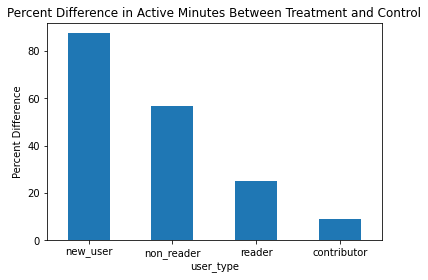

In [50]:
# make a bar chart here (x: user_type, y: percent difference)

percentDiffUserType.plot.bar(x='user_type', y='active_mins_during', rot=0, 
                             title='Percent Difference in Active Minutes Between Treatment and Control',
                             ylabel='Percent Difference')

The new users had the greatest percent difference in active minutes, while contributors experienced the least. The treatment appears to have different levels of influence based on the user type. Since this is the case, it is important that the treatment and control groups have similar percentages of each of the user types.

In [51]:
allTreat.groupby(by=['variant_number', 'user_type']).count()['uid'] / len(allTreat['variant_number']) * 100

variant_number  user_type  
1               new_user        8.401528
                non_reader     76.464812
                reader         13.747954
                contributor     1.385706
Name: uid, dtype: float64

In [52]:
allControl.groupby(by=['variant_number', 'user_type']).count()['uid'] / len(allControl['variant_number']) * 100

variant_number  user_type  
0               new_user        6.118511
                non_reader     73.523973
                reader         17.916008
                contributor     2.441508
Name: uid, dtype: float64

The treatment group has a slightly greater percentage of new_users and non_readers and a slightly lower percentage of readers and contributors. We also found that those the new_users and non_readers experience a greater change in active minutes due to the treatment than the other two user types (reader, contributor). This is problematic because this could lead us to overestimate the effects of the treatment.

### Differences in treatment effects for different genders

Another factor to consider is how the treatment may affect different genders. Some genders may be more heavily influenced than others.

In [53]:
treatMeanGender = allTreat.groupby(by=['gender']).mean()['active_mins_during']
controlMeanGender = allControl.groupby(by=['gender']).mean()['active_mins_during']

In [54]:
treatMeanGender

gender
female     355.527778
male       534.548009
unknown    386.204969
Name: active_mins_during, dtype: float64

In [55]:
controlMeanGender

gender
female     347.295635
male       555.593957
unknown    316.268939
Name: active_mins_during, dtype: float64

### Percent difference in active minutes between treatment and control groups for each gender

In [56]:
percentDiffGender = (treatMeanGender - controlMeanGender) / controlMeanGender * 100
percentDiffGender

gender
female      2.370356
male       -3.788009
unknown    22.112836
Name: active_mins_during, dtype: float64

<AxesSubplot:title={'center':'Percent Difference in Active Minutes Between Treatment and Control'}, xlabel='Gender', ylabel='Percent Difference'>

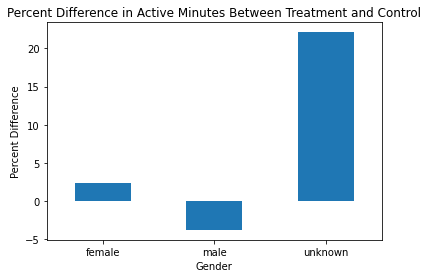

In [57]:
percentDiffGender.plot.bar(x='gender', y='active_mins_during', rot=0, 
                           title='Percent Difference in Active Minutes Between Treatment and Control',
                           xlabel = 'Gender',
                           ylabel='Percent Difference')

Females who received the treatment spent more time on the website, and males who received the treatment actually spent less time. Unknowns who received the treatment  spent especially more time on the website.

In [58]:
allTreat.groupby(by=['variant_number', 'gender']).count()['uid'] / len(allTreat['variant_number']) * 100

variant_number  gender 
1               female     28.281506
                male       55.908347
                unknown    15.810147
Name: uid, dtype: float64

In [59]:
allControl.groupby(by=['variant_number', 'gender']).count()['uid'] / len(allControl['variant_number']) * 100

variant_number  gender 
0               female     28.673653
                male       56.149331
                unknown    15.177016
Name: uid, dtype: float64

The proportions of each gender appear to be very similar for the treatment and control.